In [6]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
df = pd.read_csv("data.csv")

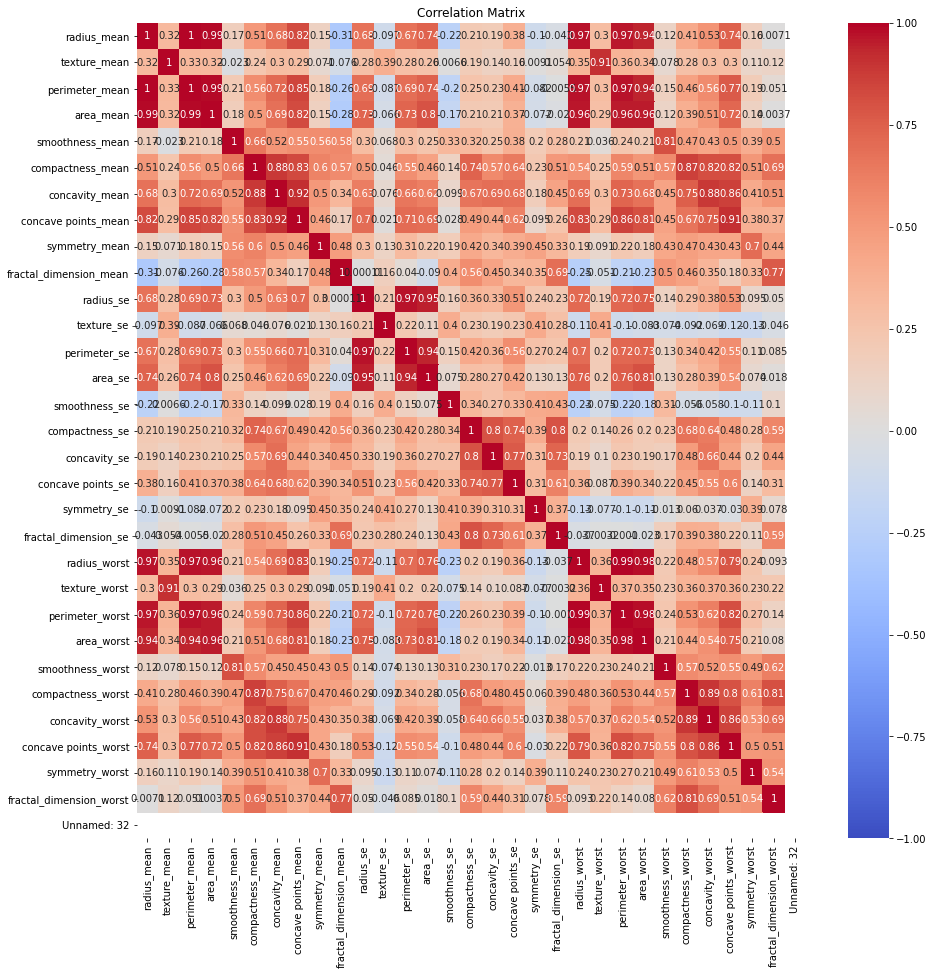

In [7]:
corrmat = df.corr()
f, ax = plt.subplots(nrows=1, ncols=1, figsize=(15, 15))
ax.set_title("Correlation Matrix", fontsize=12)
filter = df.columns != 'id'
sns.heatmap(df[df.columns[filter]].corr(), vmin=-1, vmax=1, cmap='coolwarm', annot=True)

In [15]:
import os
images = ["all-mias/"+x for x in os.listdir("all-mias")]
images

['all-mias/mdb149.pgm',
 'all-mias/mdb161.pgm',
 'all-mias/mdb175.pgm',
 'all-mias/mdb029.pgm',
 'all-mias/mdb015.pgm',
 'all-mias/mdb001.pgm',
 'all-mias/mdb217.pgm',
 'all-mias/mdb203.pgm',
 'all-mias/mdb202.pgm',
 'all-mias/mdb216.pgm',
 'all-mias/mdb014.pgm',
 'all-mias/mdb028.pgm',
 'all-mias/mdb174.pgm',
 'all-mias/mdb160.pgm',
 'all-mias/mdb148.pgm',
 'all-mias/mdb189.pgm',
 'all-mias/mdb176.pgm',
 'all-mias/mdb162.pgm',
 'all-mias/mdb002.pgm',
 'all-mias/mdb016.pgm',
 'all-mias/mdb228.pgm',
 'all-mias/mdb200.pgm',
 'all-mias/mdb214.pgm',
 'all-mias/mdb215.pgm',
 'all-mias/mdb201.pgm',
 'all-mias/mdb229.pgm',
 'all-mias/mdb017.pgm',
 'all-mias/mdb003.pgm',
 'all-mias/mdb163.pgm',
 'all-mias/mdb177.pgm',
 'all-mias/mdb188.pgm',
 'all-mias/mdb198.pgm',
 'all-mias/mdb173.pgm',
 'all-mias/mdb167.pgm',
 'all-mias/mdb007.pgm',
 'all-mias/mdb013.pgm',
 'all-mias/mdb205.pgm',
 'all-mias/mdb211.pgm',
 'all-mias/mdb239.pgm',
 'all-mias/mdb238.pgm',
 'all-mias/mdb210.pgm',
 'all-mias/mdb20

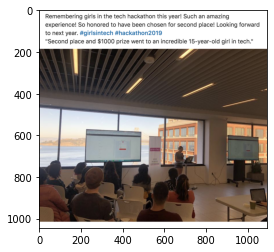

In [5]:
import matplotlib.image as mpimg
img = mpimg.imread(df.filename[0])
plt.imshow(img)


In [52]:
from PIL import Image
for x in df.REFNUM:
    Image.open("all-mias/%s.pgm"%x).save("files/%s.png"%x)
    

In [53]:
df = pd.read_csv("info.txt", delimiter=" ")
df["filename"] = "files/" + df.REFNUM +".png"
df.CLASS.unique()

array(['CIRC', 'NORM', 'MISC', 'ASYM', 'ARCH', 'SPIC', 'CALC'],
      dtype=object)

In [92]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
df["SEVERITY"] = df["SEVERITY"].fillna("None")
train_df = df.loc[:len(df)*.6-1]
validation_df = df.loc[len(df)*.6:]
# All images will be rescaled by 1./255
train_datagen = ImageDataGenerator(rescale=1/255)
validation_datagen = ImageDataGenerator(rescale=1/255)

# Flow training images in batches of 128 using train_datagen generator
train_generator = train_datagen.flow_from_dataframe(
        dataframe=train_df,
        x_col = 'filename',
        y_col = 'SEVERITY',
        target_size=(300, 300),  # All images will be resized to 300x300
        batch_size=32,
        # Since we use binary_crossentropy loss, we need binary labels
        class_mode='categorical')

validation_generator = validation_datagen.flow_from_dataframe(
        dataframe=validation_df,
        x_col = 'filename',
        y_col = 'SEVERITY',
        target_size=(300, 300),  # All images will be resized to 300x300
        batch_size=32,
        # Since we use binary_crossentropy loss, we need binary labels
        class_mode='categorical')

Found 198 validated image filenames belonging to 3 classes.
Found 132 validated image filenames belonging to 3 classes.


In [93]:
import tensorflow as tf
num_classes = 3
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (5,5), input_shape = (300 , 300 , 3), activation = 'relu'),
    tf.keras.layers.MaxPool2D(3,3),
    tf.keras.layers.Conv2D(64, (5,5) , activation = 'relu'),
    tf.keras.layers.MaxPool2D((3,3)),
    tf.keras.layers.Conv2D(128 , (5,5) , activation = 'relu'),
    tf.keras.layers.MaxPool2D(3,3),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(0.5, seed = 5),
    tf.keras.layers.Dense(128 , activation = 'relu'),
    tf.keras.layers.Dense(num_classes , activation = 'softmax')])

In [94]:
model.compile(loss = 'categorical_crossentropy' , optimizer = tf.keras.optimizers.Adam(lr = 0.001) , metrics = 'accuracy')

model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_12 (Conv2D)           (None, 296, 296, 32)      2432      
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 98, 98, 32)        0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 94, 94, 64)        51264     
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 31, 31, 64)        0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 27, 27, 128)       204928    
_________________________________________________________________
max_pooling2d_14 (MaxPooling (None, 9, 9, 128)         0         
_________________________________________________________________
flatten_4 (Flatten)          (None, 10368)            

In [95]:
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('accuracy')>0.85):
      print("\nReached 60% accuracy so cancelling training!")
      self.model.stop_training = True


callbacks = myCallback()

In [96]:
history = model.fit(train_generator ,
          validation_data = validation_generator ,
          epochs = 15 ,
          steps_per_epoch = len(train_df)/32, # train_files/batch_size
          validation_steps = len(validation_df)/32, # valid_files/batch_size 
          callbacks = [callbacks]) 

Epoch 1/15
6/6 [==============================] - 18s 3s/step - loss: 1.1957 - accuracy: 0.5039 - val_loss: 1.0146 - val_accuracy: 0.6439
Epoch 2/15
6/6 [==============================] - 20s 3s/step - loss: 0.9643 - accuracy: 0.6225 - val_loss: 0.9883 - val_accuracy: 0.6439
Epoch 3/15
6/6 [==============================] - 20s 4s/step - loss: 0.9089 - accuracy: 0.6519 - val_loss: 0.9901 - val_accuracy: 0.6439
Epoch 4/15
6/6 [==============================] - 18s 3s/step - loss: 0.8741 - accuracy: 0.6426 - val_loss: 1.0052 - val_accuracy: 0.6439
Epoch 5/15
6/6 [==============================] - 20s 3s/step - loss: 0.8534 - accuracy: 0.6425 - val_loss: 1.0796 - val_accuracy: 0.5000
Epoch 6/15
6/6 [==============================] - 20s 3s/step - loss: 0.8330 - accuracy: 0.6251 - val_loss: 1.0986 - val_accuracy: 0.4924
Epoch 7/15
6/6 [==============================] - 20s 3s/step - loss: 0.8143 - accuracy: 0.6717 - val_loss: 1.0424 - val_accuracy: 0.5985
Epoch 8/15
6/6 [==================

In [110]:
from tensorflow.keras.preprocessing import image
import numpy as np
labels = (train_generator.class_indices)
labels = dict((v , k) for k , v in labels.items())
print(labels)
def prediction(test_path):
    img = image.load_img(test_path , target_size = (300 , 300))
    img = image.img_to_array(img, dtype=np.uint8)
    img = np.array(img)/300.0
        
    plt.title('Image')
    plt.axis('off')
    plt.imshow(img.squeeze())
        
    predict = model.predict(img[np.newaxis , ...])
    predicted_class = labels[np.argmax(predict[0] , axis = -1)]
        
    print('Prediction Value: ' , np.max(predict[0] , axis = -1))
    print("Classified:",predicted_class)

{0: 'B', 1: 'M', 2: 'None'}


Prediction Value:  0.6690539
Classified: M


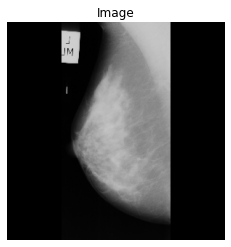

In [112]:
prediction(validation_df.iloc[1].filename)

In [113]:
validation_df.iloc[1]

REFNUM                  mdb197
BG                           D
CLASS                     NORM
SEVERITY                  None
X                          NaN
Y                          NaN
RADIUS                     NaN
Unnamed: 7                 NaN
filename      files/mdb197.png
Name: 199, dtype: object